In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

import os
from os import listdir
from os.path import isfile

In [4]:
# Вспомогательная функция для загрузки и извлечения данных

def get_data_extract():
  if "food-101" in os.listdir():
    print("Набор данных уже существует")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Набор данных загружен и извлечен!")

In [5]:
# Загружаем данные и распаковываем их в папку
get_data_extract()

4996284416/4996278331 [==============================] - 273s 0us/step
Dataset downloaded and extracted!


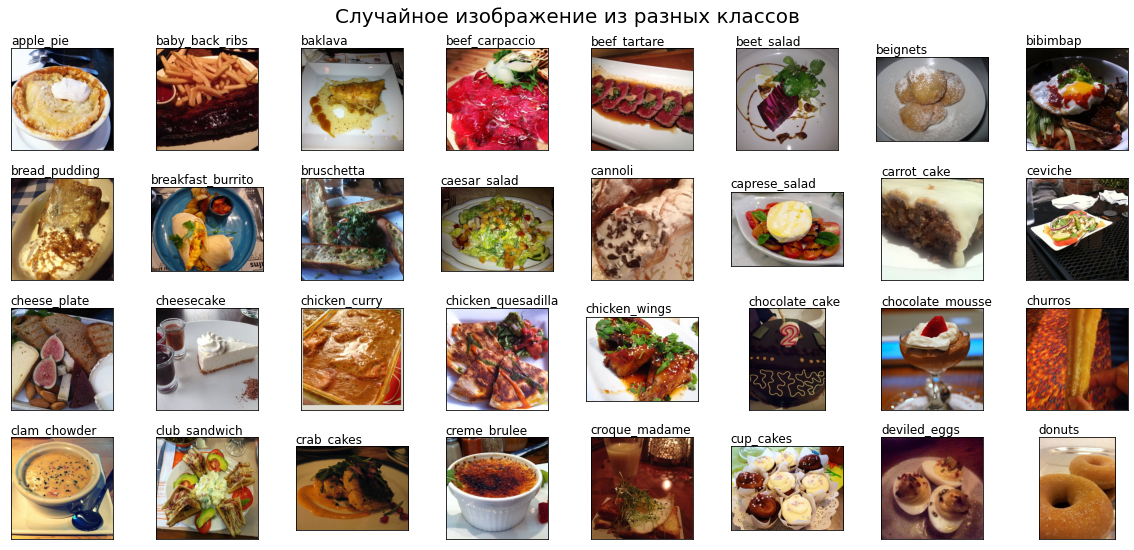

In [14]:
root_dir = 'food-101/images/'
rows = 4
cols = 8
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(16, 8))
fig.suptitle('Случайное изображение из разных классов', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ax[i][j].text(0, -20, food_dir, size=12)
        
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Определяем пути и вытаскиваем train и test

In [7]:
img_root = os.path.join('./food-101', 'images')
train_list_image = os.path.join('./food-101', 'meta', 'train.txt')
test_list_image = os.path.join('./food-101', 'meta', 'test.txt')
classes_list_image = os.path.join('./food-101', 'meta', 'classes.txt')


def image_label(img_root, list_image, classes):

    img_paths = []
    labels = []

    with open(list_image, 'r') as f:
        for line in f:
            class_name, image_id = line.strip().split('/')
            img_paths.append(os.path.join(img_root, class_name, image_id+'.jpg'))
            labels.append(classes.index(class_name))

    return img_paths, labels


with open(classes_list_image, 'r') as f:
    classes = [line.strip() for line in f]

train_data = image_label(img_root, train_list_image, classes)
val_data = image_label(img_root, test_list_image, classes)


Создание пайплайна данных

In [8]:
INPUT_SIZE = 224
NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 128
TRAIN_EXAMPLES = len(train_data[0])
VAL_EXAMPLES = len(val_data[0])

def prepare_image(img_path, label):
    data = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(data, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    return tf.image.resize(img, (INPUT_SIZE, INPUT_SIZE), method='area'), label

train_ds = tf.data.Dataset.from_tensor_slices(train_data)
train_ds = train_ds.shuffle(buffer_size=TRAIN_EXAMPLES)
train_ds = train_ds.map(prepare_image)
train_ds = train_ds.batch(TRAIN_BATCH_SIZE, drop_remainder=True)


val_ds = tf.data.Dataset.from_tensor_slices(val_data)
val_ds = val_ds.shuffle(buffer_size=VAL_EXAMPLES)
val_ds = val_ds.map(prepare_image)
val_ds = val_ds.batch(VAL_BATCH_SIZE, drop_remainder=True)



Подготовка модели CNN

In [9]:
base_model = tf.keras.applications.VGG19(
        input_shape=(INPUT_SIZE, INPUT_SIZE, 3),
        include_top=False,
        weights='imagenet',
    )
base_model.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax'),
])

80142336/80134624 [==============================] - 1s 0us/step


Подготовка к обучению

In [10]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 101)               51813     
Total params: 20,076,197
Trainable params: 20,076,197
Non-trainable params: 0
_________________________________________________________________


Обучение модели

In [12]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=val_ds
    )

Epoch 1/20
1183/1183 [==============================] - 1401s 1s/step - loss: 3.9401 - accuracy: 0.1195 - val_loss: 2.6003 - val_accuracy: 0.3591
Epoch 2/20
1183/1183 [==============================] - 1285s 1s/step - loss: 2.3552 - accuracy: 0.4206 - val_loss: 1.6462 - val_accuracy: 0.5731
Epoch 3/20
1183/1183 [==============================] - 1297s 1s/step - loss: 1.7748 - accuracy: 0.5484 - val_loss: 1.3856 - val_accuracy: 0.6373
Epoch 4/20
1183/1183 [==============================] - 1284s 1s/step - loss: 1.4565 - accuracy: 0.6225 - val_loss: 1.2144 - val_accuracy: 0.6747
Epoch 5/20
1183/1183 [==============================] - 1282s 1s/step - loss: 1.2360 - accuracy: 0.6747 - val_loss: 1.2728 - val_accuracy: 0.6712
Epoch 6/20
1183/1183 [==============================] - 1297s 1s/step - loss: 1.0636 - accuracy: 0.7150 - val_loss: 1.1985 - val_accuracy: 0.6755
Epoch 7/20
1183/1183 [==============================] - 1298s 1s/step - loss: 0.9066 - accuracy: 0.7538 - val_loss: 1.1349 -

Оценка качества модели

In [13]:
%%time

model.evaluate(val_ds)

197/197 [==============================] - 129s 651ms/step - loss: 1.8164 - accuracy: 0.7308
CPU times: user 3min 37s, sys: 7.35 s, total: 3min 45s
Wall time: 2min 8s


[1.8163845539093018, 0.7308058142662048]